# Model—Machine Learning Surrogate for MuSHrooM 

## Introduction
### Code Structure / Outline
1) Train CVAE Model
2) Train DNN (Using Generated Points in Latent Space)
3) Define and Use GAIT Model

In [29]:
# general imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# data loading and processing
import h5py
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## 1 CVAE Model

Set hyperparameters

In [31]:
# model training
lr_cvae = 0.001
num_epochs_cvae = 1000 # was 5000

# model data
batch_size_cvae = 32
input_dim = 64
latent_dim = 64

# loss weighting
w_phi = 1.0
w_grad = 10.0
w_kl = 0.01

In [17]:
hdf5_filepath = '/Users/iangill/Downloads/test_MuSHrooM_processed-60024954.h5'


Load Test and Train Data

In [65]:
# Open the HDF5 file in read mode
with h5py.File(hdf5_filepath, 'r') as f:
    # Read the datasets
    #tempIon_data = f['tempIon_data'][:]
    #denIon_data = f['denIon_data'][:]
    #tempElc_data = f['tempElc_data'][:]
    #denElc_data = f['denElc_data'][:]
    phi_data = f['phi_data'][:]
    times = f['times'][:]
    grid = f['X'][:]
    # Read the attributes (dimensions of data)
    Nx = f.attrs['Nx']
    Ny = f.attrs['Ny']
    Nt = f.attrs['Nt']

# exchange time dimension with batch dimension
phi_data = np.transpose(phi_data, (2, 1, 0))
print("Shape of data:", phi_data.shape)

Shape of data: (544, 682, 683)


Downsample dataset

[[-4.01058453e-05 -3.94273427e-05 -4.08487707e-05 ... -3.02956791e-05
  -3.25936604e-05 -3.91318028e-05]
 [-3.63544663e-05 -4.12444018e-05 -3.79457082e-05 ... -3.84012423e-05
  -3.62151604e-05 -2.98206949e-05]
 [-3.67277783e-05 -3.88534511e-05 -3.76502480e-05 ... -3.43533494e-05
  -2.90790382e-05 -3.57766532e-05]
 ...
 [-4.18358134e-05 -4.16202291e-05 -3.44037011e-05 ... -4.12722044e-05
  -3.95388825e-05 -4.28543990e-05]
 [-4.17010287e-05 -4.08291292e-05 -3.61093649e-05 ... -4.44339917e-05
  -4.33578221e-05 -4.45099562e-05]
 [-4.26931126e-05 -3.78134087e-05 -3.56040216e-05 ... -3.88133051e-05
  -4.23306340e-05 -4.62097821e-05]]


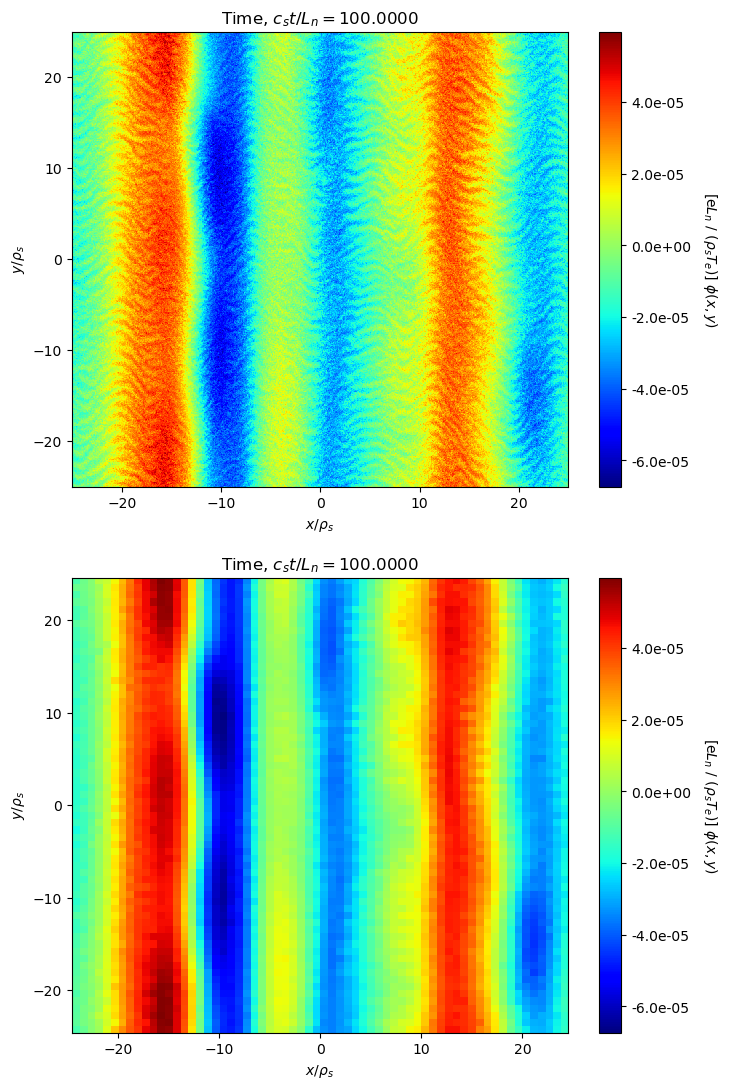

Shape of data: (544, 64, 64)


In [66]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Assuming grid and phi_data are already loaded
# grid[0, :, :] -> x-coordinates, grid[1, :, :] -> y-coordinates

# Define transform for resizing
input_dim = 64  # Target dimension for resizing
transform = transforms.Resize((input_dim, input_dim))  # Resizing to (64, 64)

# Select a test slice from phi_data
test = torch.tensor(phi_data[400, :, :].copy())  # Select test slice (2D spatial slice)
print(phi_data[1, :, :])

  # Add batch dimension for resizing

# Resize the x and y coordinate grids in `grid`
x_coords = torch.tensor(grid[0, :, :]).unsqueeze(0)  # Add batch dimension for resizing
y_coords = torch.tensor(grid[1, :, :]).unsqueeze(0)
fig, axs= plt.subplots(2,1,figsize=(8, 13))
ax1=axs[1]
ax2=axs[0]
cax2 = ax2.imshow(phi_data[400, :, :], cmap='jet', interpolation='nearest',
                extent=[x_coords.min(), x_coords.max(), 
                        y_coords.min(), y_coords.max()],
                origin='lower', aspect='auto')
test = test.unsqueeze(0)
resized_test = transform(test).squeeze().numpy()



resized_x_coords = transform(x_coords).squeeze().numpy()  # Resize x-coordinates
resized_y_coords = transform(y_coords).squeeze().numpy()  # Resize y-coordinates

# Set up the heatmap plot


# Plot the data using imshow, with the extent matching the x and y grid limits
cax = ax1.imshow(resized_test, cmap='jet', interpolation='nearest',
                extent=[resized_x_coords.min(), resized_x_coords.max(), 
                        resized_y_coords.min(), resized_y_coords.max()],
                origin='lower', aspect='auto')

# Add colorbar with scientific notation
cbar = fig.colorbar(cax, ax=ax2, format='%.1e')
cbar.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
cbar2 = fig.colorbar(cax, ax=ax1, format='%.1e')
cbar2.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)

# Set title and labels
time_value = times[0]  # Replace with dynamic time value if available
ax1.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax1.set_xlabel(r'$x / \rho_s$')
ax1.set_ylabel(r'$y / \rho_s$')
ax2.set_title(f'Time, $c_s t / L_n = {time_value:.4f}$')
ax2.set_xlabel(r'$x / \rho_s$')
ax2.set_ylabel(r'$y / \rho_s$')

plt.show()

phi_data = torch.tensor(phi_data.copy())
phi_data = transform(phi_data).numpy().astype(np.float32) 
print("Shape of data:", phi_data.shape)

def rescale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
phi_data = rescale(phi_data)


Define Dataset and create DataLoader

Train Data Loader
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
Test Data Loader
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.Size([32, 1, 64, 64])
torch.float32


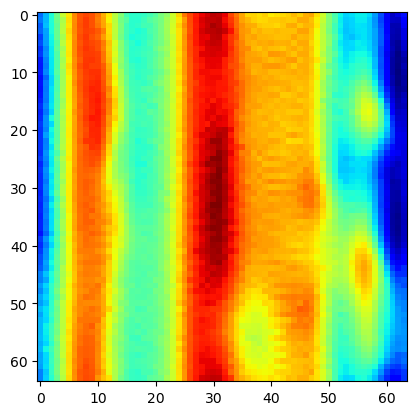

In [6]:
# define class for dataset
class PhiDataset(Dataset):
    def __init__(self, phi_data, transform=None):
        self.data = phi_data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        image = torch.tensor(self.data[idx,:,:], dtype=torch.float32)
        # Add a channel dimension to make it (1, 256, 256)
        image = image.unsqueeze(0)  # Shape becomes (1, 256, 256)

        if self.transform:
            image = self.transform(image)

        return image
    
N_train = batch_size_cvae*14

# train data loader
phi_train = PhiDataset(phi_data[0:N_train, :, :])
phi_train_loader = DataLoader(phi_train, batch_size=batch_size_cvae, shuffle=True)

# test data loader
phi_test = PhiDataset(phi_data[N_train:, :, :])
phi_test_loader = DataLoader(phi_test, batch_size=batch_size_cvae, shuffle=True)


# test data loader
print("Train Data Loader")
for batch in phi_train_loader:
    print(batch.shape)  
    
print("Test Data Loader")
for batch in phi_test_loader:
    print(batch.shape)

# plot the 5th element of the dataset
plt.figure()
plt.imshow(phi_train[10].squeeze(), cmap='jet')

first_batch = next(iter(phi_train_loader))

print(first_batch.dtype)

### Model Architecture

- Encoder $\epsilon$ (CNN)
    - Conv2D Layer with kernel size 3x3 [In: `1x600x600` Out: `?x600x600`]
    - ?Conv2D Layer with kernel size 3x3 [In: `1x600x600` Out: `1x600x600`]
    - ?Conv2D Layer with kernel size 3x3 [In: `1x600x600` Out: `1x600x600`]
    - ?Conv2D Layer with kernel size 3x3 [In: `1x600x600` Out: `1x600x600`]
    - ?Conv2D Layer with kernel size 3x3 [In: `1x600x600` Out: `1x600x600`]
    - ?Flattening Layer [In: `1x600x600` Out: `1x600x600`]
    - ?FC Layers
        - ?Mean Vector ($\mu$) Layer [In: `?` Out: `?`] — center of latent distribution
        - ?Log-variance vector ($\log{(\sigma^2)}$) — spread of latent distribution
- Latent Space (Sampling)
    - Latent vector $\mathcal{z}$
$$\mathcal{z} = \mu + e^{\frac{\log{\sigma^2}}{2}} \cdot \epsilon \quad \text{where } \epsilon \text{ is randomly drawn from std. normal distribution}$$
- Deep Neural Network (three hidden layers)
- Decoder $\mathcal{D}$ (CNN) (mirror of encoder - TBD)

Define Model Components

In [7]:
# Encoder Network with Batch Normalization
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # 64x64 -> 32x32
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 32x32 -> 16x16
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 16x16 -> 16x16
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1)  # 16x16 -> 8x8
        self.bn4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)  # 8x8 -> 8x8
        self.bn5 = nn.BatchNorm2d(128)
        
        # Fully connected layers for latent variables
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

    def forward(self, x):
        # Apply convolution -> batch normalization -> activation
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        # Flatten before fully connected layers
        x = x.view(x.size(0), -1)
        
        # Compute mu and logvar for the latent space
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [8]:
# test
encoder = Encoder(latent_dim)
mu, logvar = encoder(first_batch)

print(mu.size())

torch.Size([32, 64])


In [9]:
# test reparametrization
def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std

z = reparameterize(mu, logvar)

print(z.size())

torch.Size([32, 64])


In [10]:
# Decoder Network
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.deconv1 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1)  # 8x8 -> 8x8
        self.deconv2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)   # 8x8 -> 16x16
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)   # 16x16 -> 16x16
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 16x16 -> 32x32
        self.deconv5 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1) # 32x32 -> 64x64

    def forward(self, z):
        z = F.relu(self.fc(z))
        z = z.view(z.size(0), 128, 8, 8)  # Reshape to (batch_size, 256, 16, 16)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        z = F.relu(self.deconv4(z))
        return torch.sigmoid(self.deconv5(z))
    
# ? Should we use batch normalization in the decoder?

In [11]:
# test
decoder = Decoder(latent_dim)
reconstructed_batch = decoder(z)

In [12]:
class CVAE(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar, z # return reconstructed data, mu, logvar, and the latent state z

torch.Size([32, 1, 64, 64])


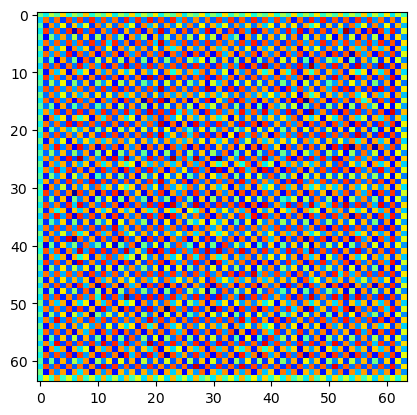

In [13]:
# test
cvae = CVAE(latent_dim)
recon_batch, mu, logvar, z = cvae(first_batch)

print(recon_batch.size())

# print first reconstructed image
plt.figure()
plt.imshow(recon_batch[0].squeeze().detach().numpy(), cmap='jet')


Define Loss Function

Our 3 weighted terms are:
1) reconstruction loss of $\phi$
2) reconstruction loss of $\nabla \phi$
3) KL divergence

In [14]:
# define function to get gradient loss
def gradient_loss(recon_x, x):
    # Ensure gradients can be computed
    x.requires_grad_(True)
    recon_x.requires_grad_(True)

    # Compute gradient of input with respect to spatial dimensions
    grad_input = torch.autograd.grad(outputs=x.sum(), inputs=x, create_graph=True)[0]

    # Compute gradient of output (reconstructed) with respect to spatial dimensions
    grad_output = torch.autograd.grad(outputs=recon_x.sum(), inputs=recon_x, create_graph=True)[0]

    # Compute L2 norm of the difference between the gradients
    grad_loss = F.mse_loss(grad_output, grad_input, reduction='sum')
    
    return grad_loss


def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') # might need to change to L2 norm
    
    recon_grad_loss = gradient_loss(recon_x, x)
    
    # KL divergence - regularizes the distribution of the latent space to be close to a standard normal distribution
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return w_phi*recon_loss + w_grad*recon_grad_loss + w_kl*kl_divergence

In [15]:
# test
loss = loss_function(recon_batch, first_batch, mu, logvar)

print(loss)

tensor(6691.3252, grad_fn=<AddBackward0>)


Initialize Model and Optimizer

In [16]:
model = CVAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=lr_cvae)

In [17]:
print(enumerate(phi_train_loader))

Train Model

In [18]:
# Training loop
for epoch in range(num_epochs_cvae):
    model.train()
    train_loss = 0
    for i, batch in enumerate(phi_train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar, z = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(phi_train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs_cvae}, Loss: {avg_loss:.4f}")

Epoch 1/1000, Loss: 107.0114
Epoch 2/1000, Loss: 36.4521
Epoch 3/1000, Loss: 16.6511
Epoch 4/1000, Loss: 14.5917
Epoch 5/1000, Loss: 9.7804
Epoch 6/1000, Loss: 8.7645
Epoch 7/1000, Loss: 6.7224
Epoch 8/1000, Loss: 6.8740
Epoch 9/1000, Loss: 6.4492
Epoch 10/1000, Loss: 5.6457
Epoch 11/1000, Loss: 5.3134
Epoch 12/1000, Loss: 5.5103
Epoch 13/1000, Loss: 4.9690
Epoch 14/1000, Loss: 4.5879
Epoch 15/1000, Loss: 4.0368
Epoch 16/1000, Loss: 3.8673
Epoch 17/1000, Loss: 3.9329
Epoch 18/1000, Loss: 3.7497
Epoch 19/1000, Loss: 4.0304
Epoch 20/1000, Loss: 4.3025
Epoch 21/1000, Loss: 4.1279
Epoch 22/1000, Loss: 4.1304
Epoch 23/1000, Loss: 3.4782
Epoch 24/1000, Loss: 3.0524
Epoch 25/1000, Loss: 2.9749
Epoch 26/1000, Loss: 3.0219
Epoch 27/1000, Loss: 2.9800
Epoch 28/1000, Loss: 2.8731
Epoch 29/1000, Loss: 2.8967
Epoch 30/1000, Loss: 2.9170
Epoch 31/1000, Loss: 2.7587
Epoch 32/1000, Loss: 2.7430
Epoch 33/1000, Loss: 2.5161
Epoch 34/1000, Loss: 2.4795
Epoch 35/1000, Loss: 2.1595
Epoch 36/1000, Loss: 2.0

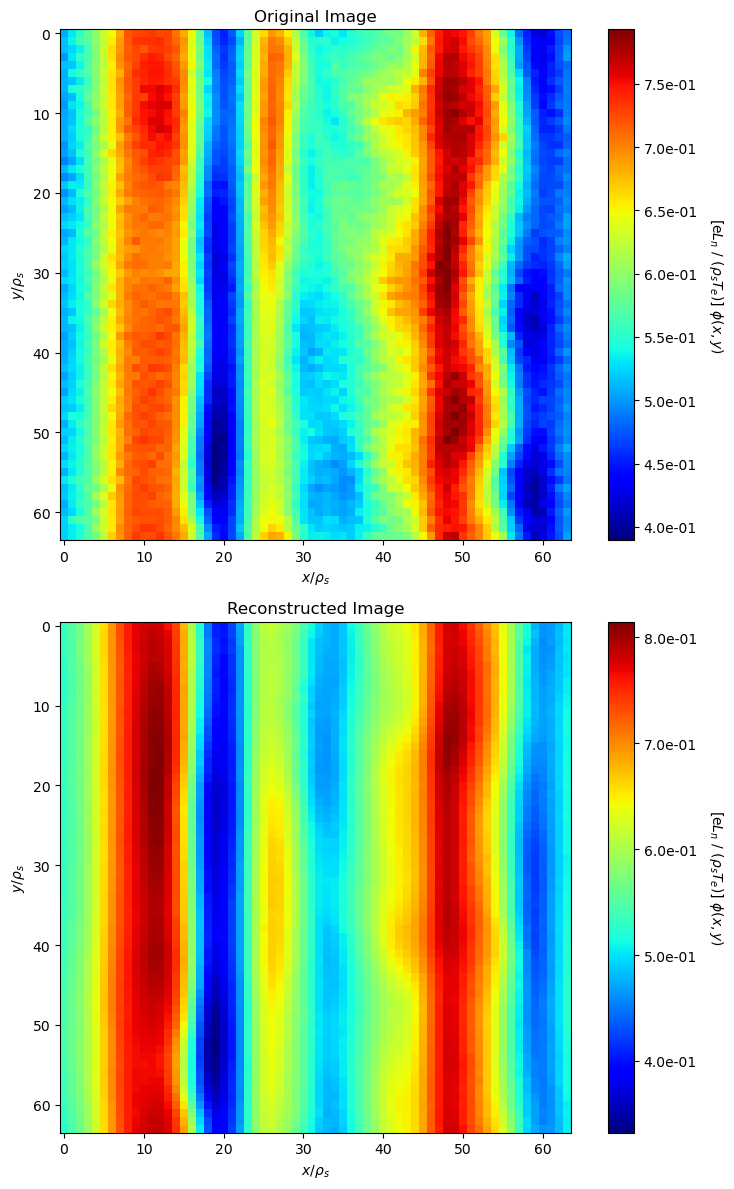

In [25]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    # Get a batch of test data
    test_batch = next(iter(phi_test_loader))
    recon_batch, mu, logvar, z = model(test_batch)
    
    # Select the 27th image from the batch for display
    original_image = test_batch[12].squeeze().numpy()
    reconstructed_image = recon_batch[12].squeeze().numpy()

    # Create a single figure with two vertically-stacked subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

    # Display the original image in the first subplot
    cax1 = ax1.imshow(original_image, cmap='jet', interpolation='nearest')
    cbar1 = fig.colorbar(cax1, ax=ax1, format='%.1e')
    cbar1.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
    ax1.set_title('Original Image')
    ax1.set_xlabel(r'$x / \rho_s$')
    ax1.set_ylabel(r'$y / \rho_s$')

    # Display the reconstructed image in the second subplot
    cax2 = ax2.imshow(reconstructed_image, cmap='jet', interpolation='nearest')
    cbar2 = fig.colorbar(cax2, ax=ax2, format='%.1e')
    cbar2.set_label(r'[e$L_n$ / ($\rho_s T_e$)] $\phi(x, y)$', rotation=270, labelpad=20)
    ax2.set_title('Reconstructed Image')
    ax2.set_xlabel(r'$x / \rho_s$')
    ax2.set_ylabel(r'$y / \rho_s$')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

In [239]:
# save model
torch.save(model.state_dict(), 'CVAE_model.pth')

## DNN Model

## GAIT Model